# Titanic Dataset Survivor Prediction - Ayaan Danish

Importing Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score

Reading the data

In [74]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df, df_test])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Understanding and Preparation

Number of rows and columns in the data

In [51]:
df.shape

(1309, 12)

Basic info about data types and null values

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


Correlation between all numeric variables

In [53]:
df.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.020370,-0.038354,0.028814,-0.055224,0.008942,0.031428
Survived,-0.020370,1.000000,-0.264710,-0.053695,0.002370,0.108919,0.233622
Pclass,-0.038354,-0.264710,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,0.028814,-0.053695,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,0.002370,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.108919,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.233622,-0.558629,0.178740,0.160238,0.221539,1.000000


Number of null values in each column. Cabin and Age column need addressing

In [54]:
df.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Replacing the null Age values with the average Age

In [55]:
avg_age = df['Age'].mean()
np.round(avg_age, 1)
df['Age'].replace(np.nan, avg_age, inplace=True)

Dropping the Name, Cabin, and Ticket columns as, as testing revealed that they are causing overfitting during model training and they don't impact model performance

In [56]:
df.drop(columns=['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

Checking updated number of null values (1 or 2 rows are negligible and testing revealed that keeping them is helping the model performance)

In [57]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       2
dtype: int64

## Data Visualization

Pie chart of overall survival rate

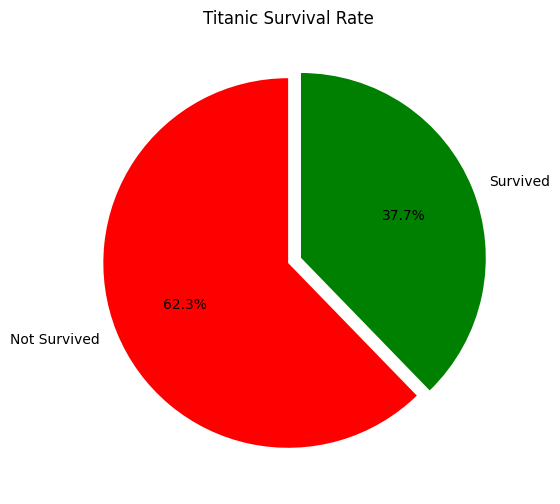

In [58]:
plt.figure(figsize=(6, 6))
plt.pie(df['Survived'].value_counts(), labels=['Not Survived', 'Survived'], autopct='%1.1f%%', startangle=90, colors=['red', 'green'], explode=[0, 0.075])
plt.title('Titanic Survival Rate')
plt.show()

Bar chart of survivors by seating class

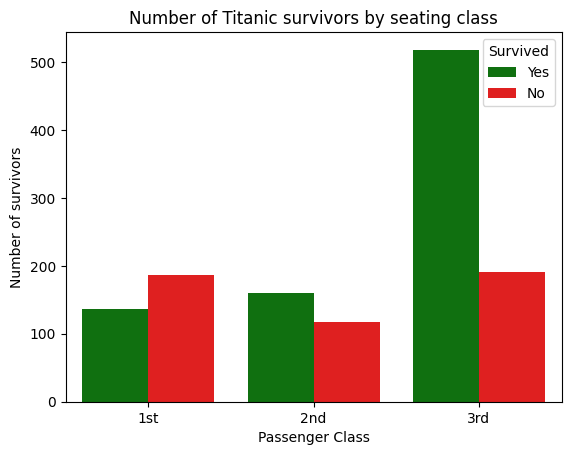

In [59]:
ax = sns.countplot(x = 'Pclass', hue='Survived', data=df, palette=['Green', 'Red'])
ax.set_xticklabels(['1st', '2nd', '3rd'])
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Number of survivors')
ax.set_title('Number of Titanic survivors by seating class')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Yes', 'No'], title='Survived')

Bar chart of survivors by relatives on board

Text(0.5, 1.0, 'Survivors by Number of siblings or spouses')

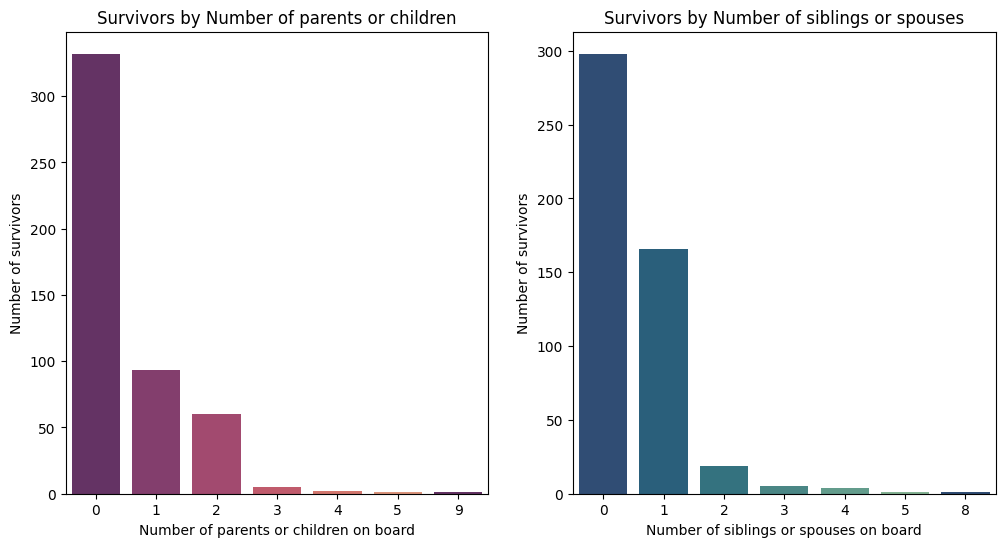

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x='Parch', data=df[df['Survived'] == 1], ax=axes[0], palette=sns.color_palette("flare_r"))
axes[0].set_ylabel('Number of survivors')
axes[0].set_xlabel('Number of parents or children on board')
axes[0].set_title('Survivors by Number of parents or children')

sns.countplot(x='SibSp', data=df[df['Survived'] == 1], ax=axes[1], palette=sns.color_palette("crest_r"))
axes[1].set_ylabel('Number of survivors')
axes[1].set_xlabel('Number of siblings or spouses on board')
axes[1].set_title('Survivors by Number of siblings or spouses')

## Data Modeling using Decision Tree

Splitting the data into test and train partitions (33% of the data is used for testing)

In [61]:
X = pd.get_dummies(df.drop(columns=['Survived'], axis=0))
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

We'll model our data using a Decision Tree Classifier. We start by performing Grid Search with various hyperparameters to find the best combination

In [62]:
param_grid = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=6)

grid_search.fit(X, y)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Accuracy: 0.8664122137404581


The above output shows the hyperparamters that lead to the best accuracy, so we create our model with them and train it on our data

In [63]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1, min_samples_split=2)
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7)

## Model Evaluation

We perform cross-validation on 5 different training-testing subsets of the data and compare their accuracies

In [64]:
scores = cross_val_score(dt, X, y, cv=5)
for fold, score in enumerate(scores, start=1):
    print(f'Fold {fold}: Accuracy = {score:.2f}')

# Calculate and print the average accuracy
average_accuracy = scores.mean()
print(f'Average Accuracy: {average_accuracy:.2f}')

Fold 1: Accuracy = 0.81
Fold 2: Accuracy = 0.81
Fold 3: Accuracy = 0.82
Fold 4: Accuracy = 0.90
Fold 5: Accuracy = 1.00
Average Accuracy: 0.87


We'll then calculate common evaluation metrics for the model to judge its performance

In [65]:
y_pred = dt.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\x1b[34mDecision Tree Model Evaluation Metrics:\x1b[0m")
print(
    f"Accuracy:\x1b[32m {accuracy*100:.5f}%\x1b[0m\
    \nPrecision:\x1b[32m {precision*100:.5f}%\x1b[0m\
    \nRecall:\x1b[32m {recall*100:.5f}%\x1b[0m\
    \nF1 Score:\x1b[32m {f1*100:.5f}%\x1b[0m"
)

Decision Tree Model Evaluation Metrics:
Accuracy: 89.12037%    
Precision: 91.01796%    
Recall: 82.60870%    
F1 Score: 86.60969%


Plotting the confusion matrix for the model

([<matplotlib.axis.YTick at 0x25cdbfc1610>,
 [Text(0, 0.5, "Didn't Survive"), Text(0, 1.5, "Didn't Survived")])

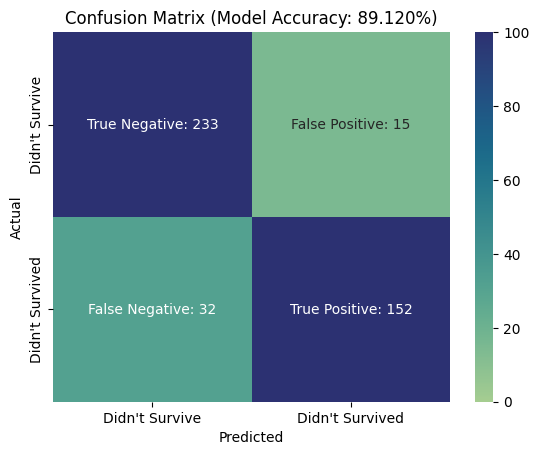

In [66]:
cm = confusion_matrix(y_test, y_pred)

annot = [[f'True Negative: {cm[0][0]}', f'False Positive: {cm[0][1]}'],
          [f'False Negative: {cm[1][0]}', f'True Positive: {cm[1][1]}']]

# Create a heatmap for the confusion matrix
ax = sns.heatmap(cm, annot=annot, cmap=sns.color_palette("crest", as_cmap=True), fmt='', vmin=-0, vmax= 100)

# Set labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.3f}%)")
plt.xticks([0.5,1.5], ["Didn't Survive", "Didn't Survived"])
plt.yticks([0.5, 1.5], ["Didn't Survive", "Didn't Survived"])

Plotting the ROC Curve. The area under the curve (AUC) is a good measure of the model's performance

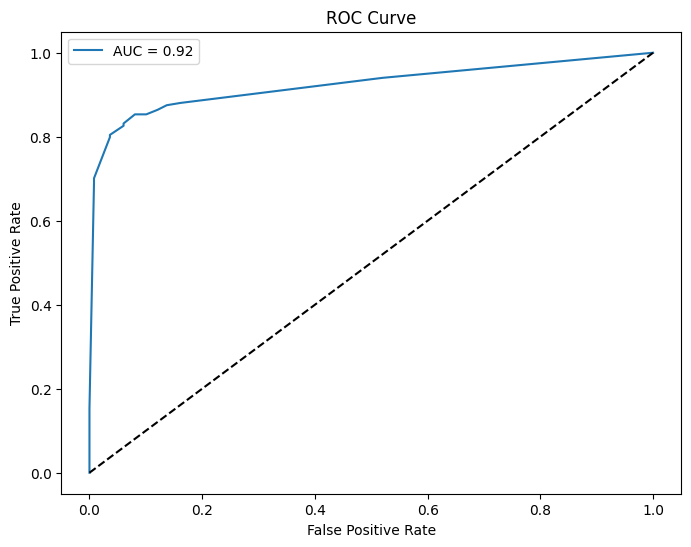

In [67]:
y_pred_prob = dt.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Finally, we plot and visualize the actual decision tree that was used to make the predictions

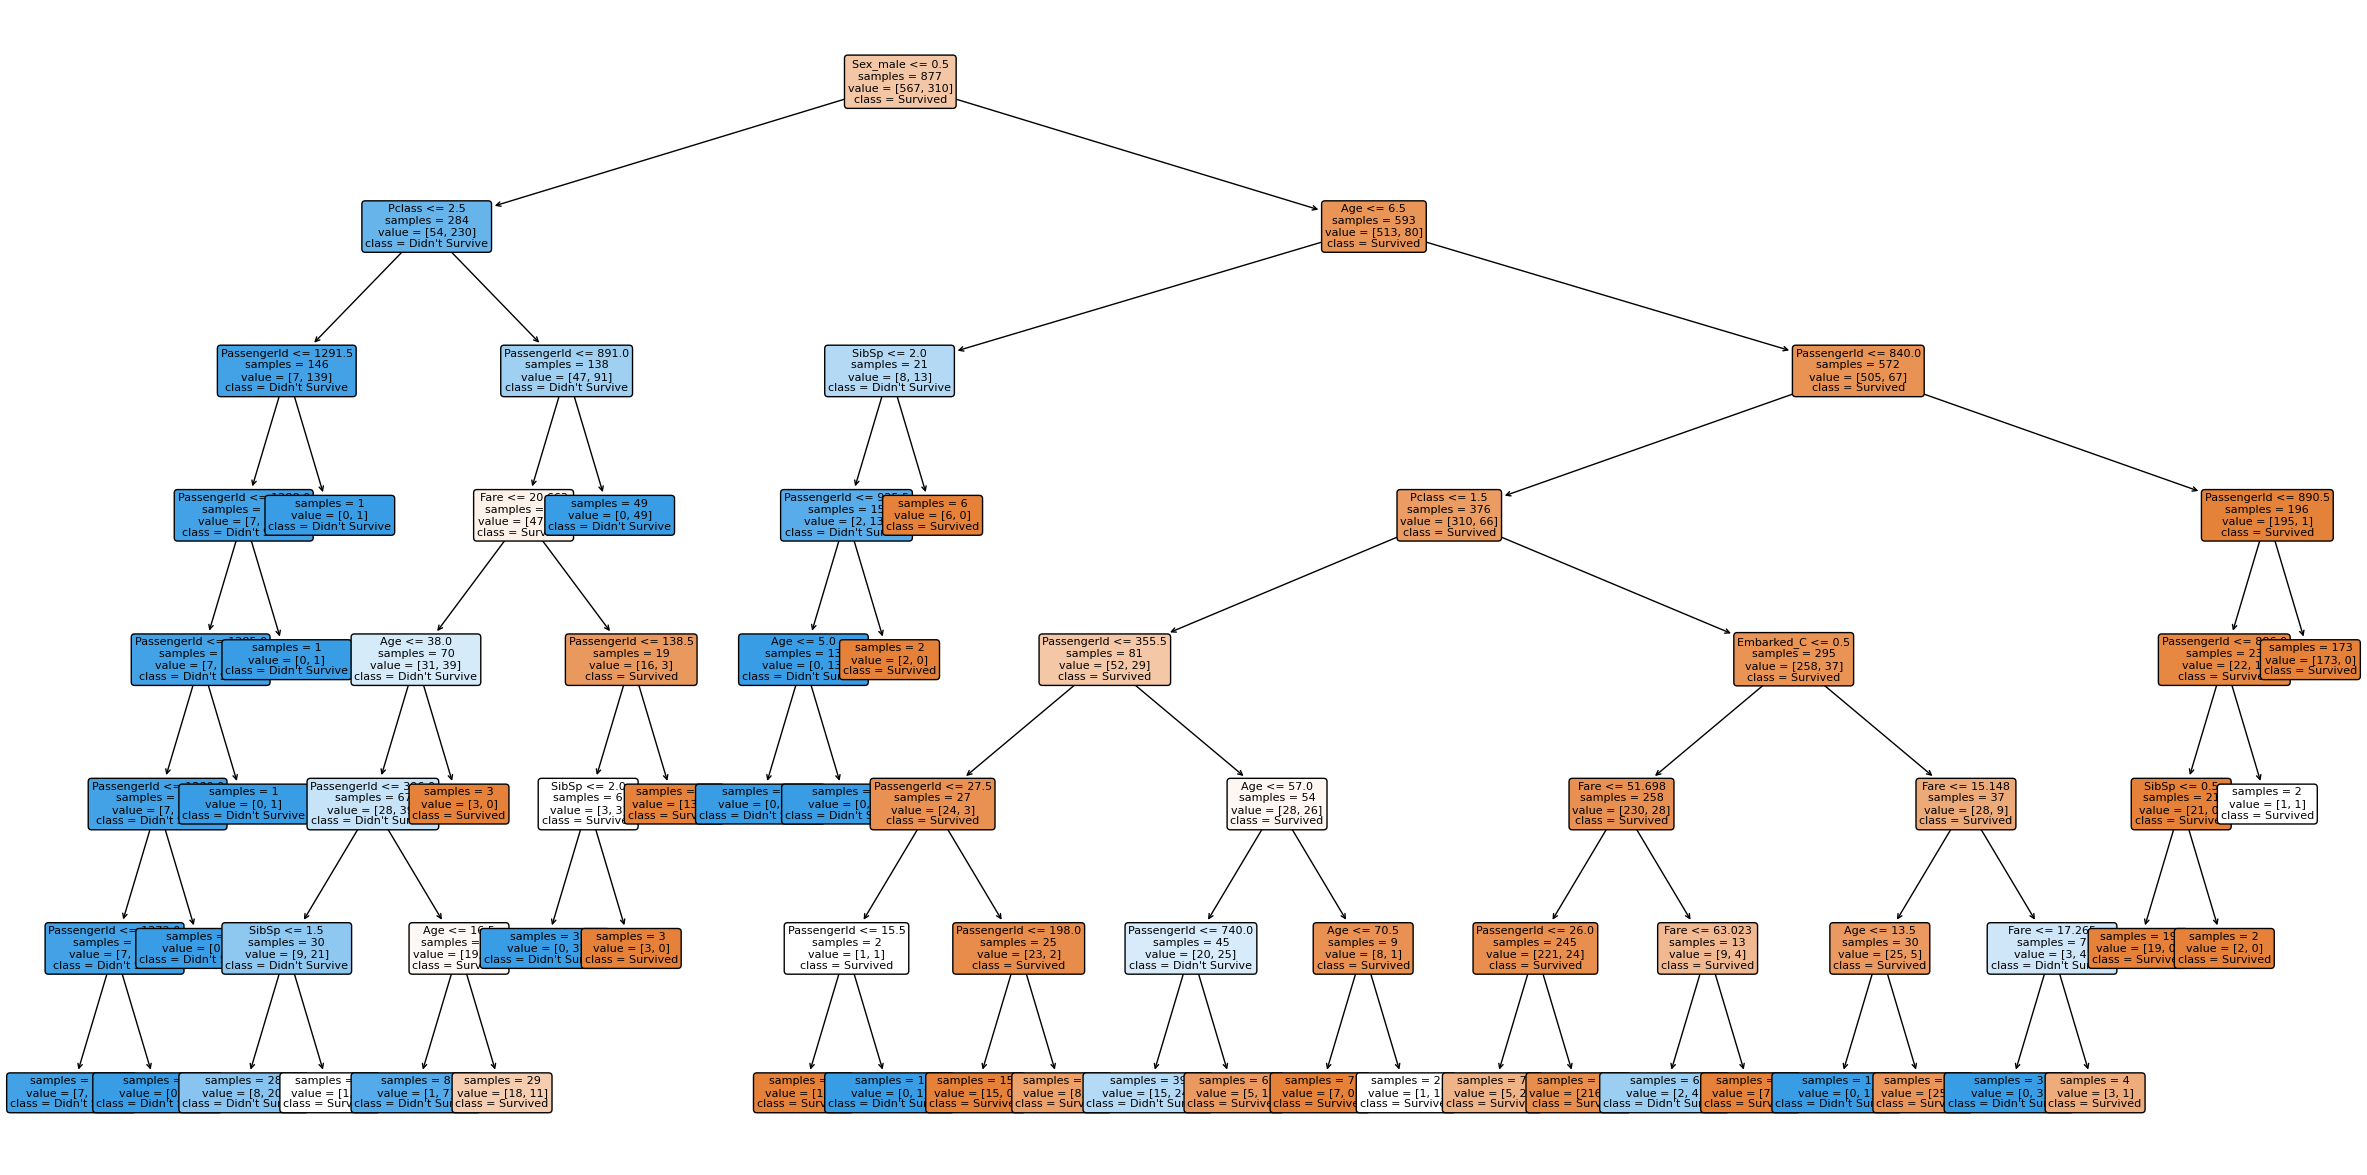

In [73]:
plt.figure(figsize=(30, 15))
annotations = plot_tree(
    dt,
    rounded=True,
    filled=True,
    fontsize=8,
    feature_names=list(x_train.columns),
    class_names=["Survived", "Didn't Survive"],
    impurity=False
)